<a href="https://colab.research.google.com/github/OlhaZahrebelna/python_for_ds_task/blob/main/Zahrebelna_Olha%22HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    RocCurveDisplay,
    roc_auc_score,
    PrecisionRecallDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

In [2]:
df = pd.read_csv('/content/train.csv')
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [3]:
target_col = "Exited"
group_col = "CustomerId"

input_cols = [c for c in df.columns if c not in [target_col, group_col, "Surname"]]

# Client stratified
cust_y = (
    df.groupby(group_col, as_index=False)[target_col]
      .max()
      .rename(columns={target_col: "cust_target"})
)


train_ids, val_ids = train_test_split(
    cust_y[group_col],
    test_size=0.2,
    random_state=42,
    stratify=cust_y["cust_target"]
)

train_ids = set(train_ids)
val_ids = set(val_ids)

train_df = df[df[group_col].isin(train_ids)].copy()
val_df   = df[df[group_col].isin(val_ids)].copy()

In [4]:
train_inputs  = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs    = val_df[input_cols]
val_targets   = val_df[target_col]

# sanity checks
assert set(train_df[group_col]).isdisjoint(set(val_df[group_col])), "CustomerId leakage!"
print(train_inputs.shape, val_inputs.shape)
print("Exited mean (rows):", train_targets.mean(), val_targets.mean())

(12022, 11) (2978, 11)
Exited mean (rows): 0.20370986524704707 0.2024848891873741


In [5]:
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

In [6]:
numeric_cols_model = [c for c in numeric_cols if c != 'id']

assert train_inputs[categorical_cols + numeric_cols_model].isna().sum().sum() == 0
assert val_inputs[categorical_cols + numeric_cols_model].isna().sum().sum() == 0

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_model),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)

X_train = preprocessor.fit_transform(train_inputs)
X_val   = preprocessor.transform(val_inputs)

feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names, index=train_inputs.index)
X_val   = pd.DataFrame(X_val,   columns=feature_names, index=val_inputs.index)

In [8]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

model.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [9]:
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

In [10]:
val_proba = model.predict_proba(val_inputs)[:, 1]
roc_auc = roc_auc_score(val_targets, val_proba)

In [11]:
def evaluate_binary(clf, X, y, title_prefix="", threshold=0.5, show_plots=True):
    """
    Evaluate binary classifier on (X, y).

    Parameters
    ----------
    clf : fitted estimator (supports predict_proba or decision_function)
    X : array-like or DataFrame
    y : array-like
    title_prefix : str
    threshold : float
        Threshold for converting scores to class predictions (default 0.5).
    show_plots : bool
        Whether to display confusion matrix + ROC + PR curves.

    Returns
    -------
    dict with metrics: auroc, ap, f1, threshold
    """
    if hasattr(clf, "decision_function"):
        scores = clf.decision_function(X)
    elif hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(X)[:, 1]
    else:
        raise AttributeError("Classifier must have 'decision_function' or 'predict_proba' method")

    pred = (scores >= threshold).astype(int)

    auroc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)
    f1 = f1_score(y, pred)

    print(f"{title_prefix} AUROC: {auroc:.4f}")
    print(f"{title_prefix} AP (PR-AUC): {ap:.4f}")
    print(f"{title_prefix} F1@{threshold:.2f}: {f1:.4f}")

    if show_plots:
        cm = confusion_matrix(y, pred)
        ConfusionMatrixDisplay(cm).plot(values_format="d")
        plt.title(f"{title_prefix} Confusion Matrix (thr={threshold:.2f})")
        plt.show()

        # ROC Curve
        RocCurveDisplay.from_predictions(y, scores)
        plt.title(f"{title_prefix} ROC Curve (AUC={auroc:.4f})")
        plt.show()

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y, scores)
        plt.title(f"{title_prefix} Precision-Recall Curve (AP={ap:.4f})")
        plt.show()

    return {"auroc": auroc, "ap": ap, "f1": f1, "threshold": threshold}


Validation AUROC: 0.8861
Validation AP (PR-AUC): 0.6908
Validation F1@0.50: 0.6750


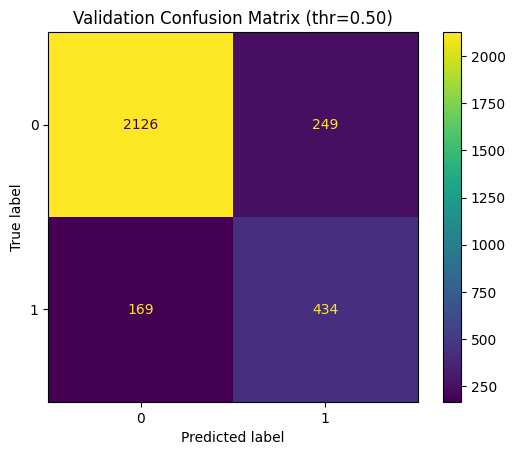

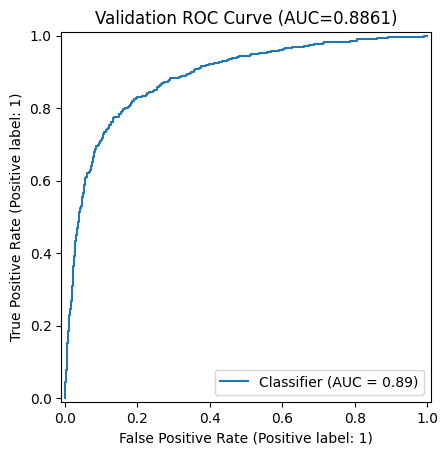

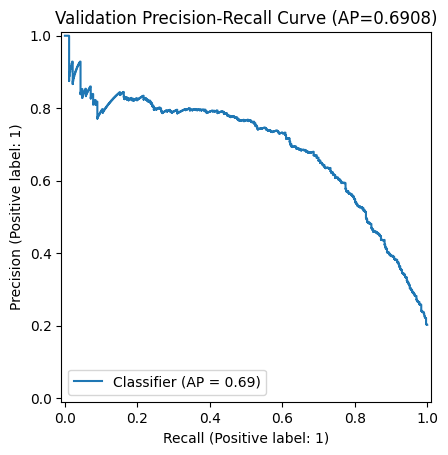

Train AUROC: 0.8824
Train AP (PR-AUC): 0.6965
Train F1@0.50: 0.6726


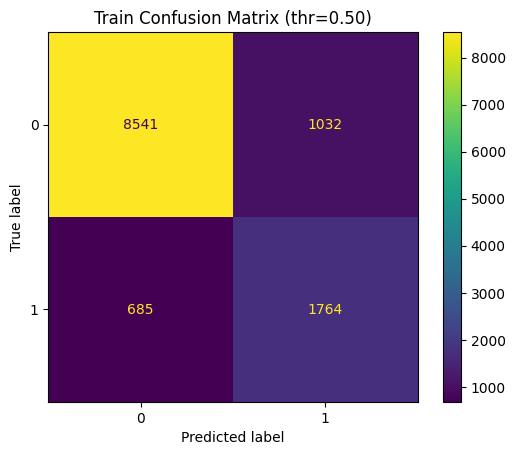

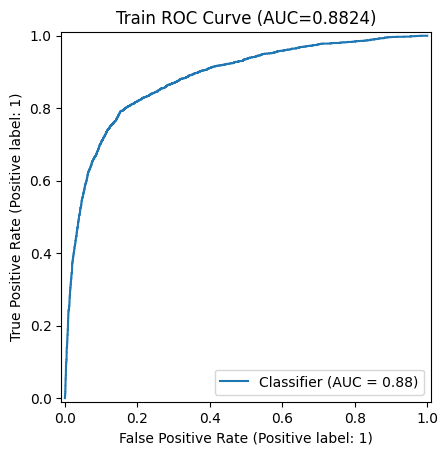

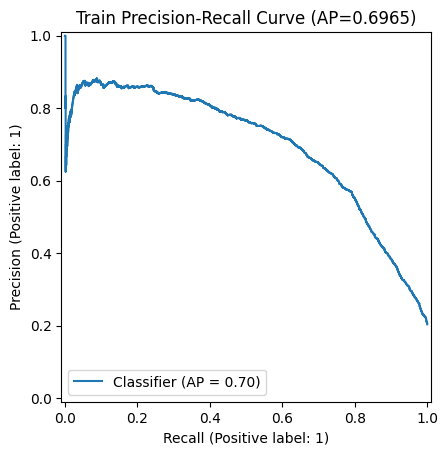

{'auroc': np.float64(0.8823918946188872),
 'ap': np.float64(0.6965018966338652),
 'f1': 0.6726406101048618,
 'threshold': 0.5}

In [12]:
evaluate_binary(model, val_inputs, val_targets, title_prefix="Validation")
evaluate_binary(model, train_inputs, train_targets, title_prefix="Train")

Area under ROC score on train dataset: 0.82%


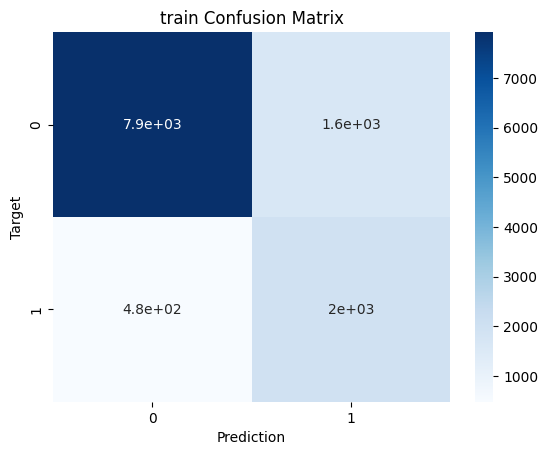

Area under ROC score on val dataset: 0.82%


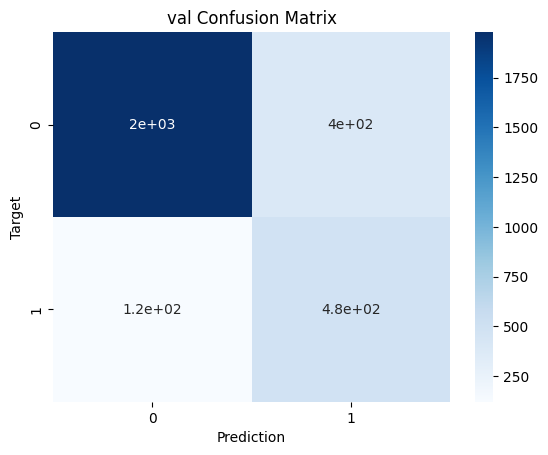

In [13]:
train_preds = predict_and_plot(model, train_inputs, train_targets, name='train')
val_preds = predict_and_plot(model, val_inputs, val_targets, name='val')

In [14]:
joblib.dump(model, 'model.joblib')


['model.joblib']

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [15]:
numeric_poly_preprocessor = Pipeline(steps=[
    ('num', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

categorical_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_poly_preprocessor, numeric_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ],
    remainder="drop"
)

model_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

In [16]:
model_poly2.fit(train_inputs, train_targets)

target_pred_train = model_poly2.predict(train_inputs)
target_pred_val = model_poly2.predict(val_inputs)


target_proba_train = model_poly2.predict_proba(train_inputs)[:, 1]
target_proba_val = model_poly2.predict_proba(val_inputs)[:, 1]


def print_metrics(y_true, y_pred, y_proba, title):
    print(f"\n{title}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1       :", f1_score(y_true, y_pred, zero_division=0))
    print("ROC-AUC  :", roc_auc_score(y_true, y_proba))

In [17]:
print_metrics(train_targets, target_pred_train, target_proba_train, "Train")
print_metrics(val_targets, target_pred_val, target_proba_val, "Validation")


Train
Accuracy : 0.8511894859424388
Precision: 0.5933257918552036
Recall   : 0.8566761943650469
F1       : 0.7010860484544695
ROC-AUC  : 0.9314709939658196

Validation
Accuracy : 0.8552719946272667
Precision: 0.6002331002331003
Recall   : 0.8540630182421227
F1       : 0.7049965776865161
ROC-AUC  : 0.9286647464432224


Модель добре генералізує. Бо показники на train дуже схожі з показникам на val.

Recall 0.85 — модель добре знаходить позитивний клас (мало пропусків)

Precision 0.60 — при цьому є відчутна кількість false positives

F1 0.705 — збалансовано непогано.

In [18]:
def predict_raw_df(model, input_cols, input_df: pd.DataFrame):
    """
    model: натренований sklearn Pipeline (preprocess + LogisticRegression)
    input_cols: список колонок, які подаються на вхід (без Exited, CustomerId, Surname)
    input_df: "сирий" DataFrame (як train/test)
    """
    X_input = input_df[input_cols].copy()
    prob = model.predict_proba(X_input)[:, 1]
    return prob


In [19]:
raw_test_df = pd.read_csv('/content/test.csv')
raw_test_df = raw_test_df.reset_index(drop=True)

In [20]:
raw_test_df["Exited"] = predict_raw_df(model_poly2, input_cols, raw_test_df)
raw_test_df[["Exited"]].head()

,Exited
0,0.299243
1,0.041171
2,0.171581
3,0.599144
4,0.058005


In [21]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_submission['Exited'] = raw_test_df['Exited']
sample_submission.to_csv('submission.csv', index=False)

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [22]:
numeric_poly4_preprocessor = Pipeline(steps=[
    ('num', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

categorical_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ("num_poly4", numeric_poly4_preprocessor, numeric_cols),
        ("cat", categorical_preprocessor, categorical_cols),
    ],
    remainder="drop"
)

model_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(max_iter=4000))
])

In [23]:
model_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_poly4',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['id', 'CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(max_iter=4000))])

In [24]:
target_pred_train4 = model_poly4.predict(train_inputs)
target_pred_val4 = model_poly4.predict(val_inputs)

target_proba_train4 = model_poly4.predict_proba(train_inputs)[:, 1]
target_proba_val4 = model_poly4.predict_proba(val_inputs)[:, 1]

print_metrics(train_targets, target_pred_train4, target_proba_train4, "Train poly4")
print_metrics(val_targets, target_pred_val4, target_proba_val4, "Validation poly4")


Train poly4
Accuracy : 0.9108301447346532
Precision: 0.8258400378608614
Recall   : 0.7125357288689261
F1       : 0.7650153441473038
ROC-AUC  : 0.9507457193071043

Validation poly4
Accuracy : 0.8848220282068502
Precision: 0.7610441767068273
Recall   : 0.6285240464344942
F1       : 0.6884650317892824
ROC-AUC  : 0.9006923278345116


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [25]:
reg_df = pd.read_csv('/content/regression_data.csv')
reg_df.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482


In [26]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


In [27]:
target_col_reg = 'target'
features = reg_df.columns.tolist()
features.remove(target_col_reg)

In [28]:
print(features)

['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']


In [29]:
X = reg_df[features]
y = reg_df[target_col_reg]

In [30]:
train_X_reg, test_X_reg, train_y_reg, test_y_reg = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
pipeline_reg = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipeline_reg.fit(train_X_reg, train_y_reg)

Pipeline(steps=[('poly', PolynomialFeatures(degree=5, include_bias=False)),
                ('scaler', StandardScaler()), ('lr', LinearRegression())])

In [32]:
target_pred_train_reg = pipeline_reg.predict(train_X_reg)
target_pred_val_reg = pipeline_reg.predict(test_X_reg)

In [33]:
target_proba_train_reg = pipeline_reg.predict(train_X_reg)
target_proba_val_reg = pipeline_reg.predict(test_X_reg)

In [34]:
def print_regression_metrics(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{title}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

print_regression_metrics(train_y_reg, target_pred_train_reg, "Train reg")
print_regression_metrics(test_y_reg, target_pred_val_reg, "Validation reg")


Train reg
MSE: 0.0000
RMSE: 0.0000
R2 Score: 1.0000

Validation reg
MSE: 160.6987
RMSE: 12.6767
R2 Score: 0.9311


In [35]:
poly_transformer = pipeline_reg.named_steps['poly']
X_train_poly_transformed = poly_transformer.fit_transform(train_X_reg)
print("К-сть ознак після poly:", X_train_poly_transformed.shape[1])

К-сть ознак після poly: 251


На train модель показує якість (RMSE=0, R²=1). На test якість нижча (RMSE≈12.68, R²≈0.93), тобто спостерігається розрив між train і test — ознака перенавчання. Також ми маємо 251 ознаку і всього 129 спостережень.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [36]:
poly = PolynomialFeatures(degree=20, include_bias=False)

X_train_poly = poly.fit_transform(train_X_reg)
X_val_poly   = poly.transform(test_X_reg)

scaler = StandardScaler(with_mean=False)  # важливо для sparse; якщо dense — можна StandardScaler()
X_train_poly_sc = scaler.fit_transform(X_train_poly)
X_val_poly_sc   = scaler.transform(X_val_poly)

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge_1", Ridge(alpha=1.0)),
    ("Ridge_2", Ridge(alpha=2.0)),
    ("Lasso_1", Lasso(alpha=1.0, max_iter=20000)),
    ("ElasticNet_1", ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=20000)),
    ("ElasticNet_0.5", ElasticNet(alpha=0.5, l1_ratio=0.5, max_iter=20000)),
]

In [38]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

for name, model in models:
    model.fit(X_train_poly_sc, train_y_reg)

    train_rmse = rmse(train_y_reg, model.predict(X_train_poly_sc))
    val_rmse   = rmse(test_y_reg,   model.predict(X_val_poly_sc))

    print(f"{name}: train RMSE={train_rmse:.6f} | val RMSE={val_rmse:.6f}")

LinearRegression: train RMSE=0.000000 | val RMSE=65.391185
Ridge_1: train RMSE=1.053670 | val RMSE=27.797604
Ridge_2: train RMSE=1.664993 | val RMSE=20.614656
Lasso_1: train RMSE=1.479369 | val RMSE=1.392128
ElasticNet_1: train RMSE=12.044328 | val RMSE=20.624002
ElasticNet_0.5: train RMSE=8.602683 | val RMSE=17.329884


Для поліноміальних ознак до степеня 20 лінійна регресія сильно перенавчається (train RMSE=0, val RMSE≈65). Ridge зменшує перенавчання, але дає значно більшу помилку на валідації (val RMSE≈20–28). Найкраще генералізує Lasso (val RMSE≈1.39) з малим розривом між train і val. ElasticNet має великий RMSE.